In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import uuid
from sentence_transformers import SentenceTransformer
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/admin/VS Code Projects/TwitchSight/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
twitch = pd.read_csv('data/dataset/twitch_ideas_with_BERT_embeddings.csv')
twitch.head()

,Author,Title,Description,VoteCount,NumComments,Topic,Category,Date,uuid,BERT_embedding
0,iateyourpie,Keep Moments,Moments is a feature that Twitch released as a...,4191,453,Stream Chat,Chat,31-Aug-23,9ec26a3c-f58d-448a-a6d9-81374a196099,[-2.33144253e-01 -5.99343926e-02 2.41251122e-...
1,iAndy88,Verified status for everyone and /verifiedonly...,I would appreciate a very helpful feature for ...,4049,246,Feature Request,Chat,12-Jan-21,fe4ffccb-41a7-43aa-8315-5d7ad1359525,[-0.32630354 -0.1644918 -0.0832853 -0.320167...
2,GohgoDude,Channel Points Leaderboard,Provide two leaderboards for channels that hav...,1883,21,Leaderboards,Chat,8-Jan-20,3a09216b-de6c-45b0-92f8-c52df11f66c2,[ 0.05259177 -0.20050193 -0.18675062 -0.406023...
3,Victor_sueca,/spoiler command,Users sending a spoiler could use this command...,817,15,Commands,Chat,17-Dec-16,d148a570-1f71-42e3-9680-1534e2af516d,[-3.89486223e-01 4.83136736e-02 1.72906816e-...
4,xSwagzy,Birthday Badge,It would be nice to have a birthday badge for ...,597,11,Feature Request,Chat,27-Nov-19,c6c20c0b-d61a-4d42-91fc-adf5049426d3,[-4.19030815e-01 3.81848723e-01 -3.61359119e-...


In [3]:
def convert_embedding(string_embedding):
    try:
        # Remove brackets
        string_embedding = string_embedding.strip('[]')
        # Replace newline characters with spaces
        string_embedding = string_embedding.replace('\n', ' ')
        # Split the string by spaces and filter out empty strings
        elements = [elem for elem in string_embedding.split(' ') if elem]
        # Convert elements to floats and create a numpy array
        return np.array([float(elem) for elem in elements])
    except Exception as e:
        # In case of any error, return a zero vector or handle appropriately
        print("Error:", e)  # Optionally print the error for debugging

twitch['BERT_embedding'] = twitch['BERT_embedding'].apply(convert_embedding)
twitch.head()

,Author,Title,Description,VoteCount,NumComments,Topic,Category,Date,uuid,BERT_embedding
0,iateyourpie,Keep Moments,Moments is a feature that Twitch released as a...,4191,453,Stream Chat,Chat,31-Aug-23,9ec26a3c-f58d-448a-a6d9-81374a196099,"[-0.233144253, -0.0599343926, 0.0241251122, -0..."
1,iAndy88,Verified status for everyone and /verifiedonly...,I would appreciate a very helpful feature for ...,4049,246,Feature Request,Chat,12-Jan-21,fe4ffccb-41a7-43aa-8315-5d7ad1359525,"[-0.32630354, -0.1644918, -0.0832853, -0.32016..."
2,GohgoDude,Channel Points Leaderboard,Provide two leaderboards for channels that hav...,1883,21,Leaderboards,Chat,8-Jan-20,3a09216b-de6c-45b0-92f8-c52df11f66c2,"[0.05259177, -0.20050193, -0.18675062, -0.4060..."
3,Victor_sueca,/spoiler command,Users sending a spoiler could use this command...,817,15,Commands,Chat,17-Dec-16,d148a570-1f71-42e3-9680-1534e2af516d,"[-0.389486223, 0.0483136736, 0.172906816, -0.2..."
4,xSwagzy,Birthday Badge,It would be nice to have a birthday badge for ...,597,11,Feature Request,Chat,27-Nov-19,c6c20c0b-d61a-4d42-91fc-adf5049426d3,"[-0.419030815, 0.381848723, -0.0361359119, -0...."


# Prepare train eval test data

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

min_instances = 10

# Filter categories with at least min_instances instances
twitch['VoteCount'] = pd.to_numeric(twitch['VoteCount'], errors='coerce')
category_counts = twitch['Category'].value_counts()
categories_to_keep = category_counts[category_counts >= min_instances].index
filtered_data = twitch[twitch['Category'].isin(categories_to_keep)].copy()

Category-wise normalization

In [10]:
# Dictionary to store min-max values for each category
min_max_values = {}

# Grouping data by category and normalizing VoteCount within each category
grouped_data = filtered_data.groupby('Category')

for name, group in grouped_data:
    min_val = group['VoteCount'].min()
    max_val = group['VoteCount'].max()
    scaler = MinMaxScaler().fit(group['VoteCount'].values.reshape(-1, 1))

    # Storing the min and max values in the dictionary
    min_max_values[name] = (min_val, max_val)

    # Applying normalization
    normalized_votes = scaler.transform(group['VoteCount'].values.reshape(-1, 1))
    filtered_data.loc[filtered_data['Category'] == name, 'Normalized_VoteCount'] = normalized_votes.flatten()

print('Min-max values for each category:')
print(min_max_values)

Min-max values for each category:
{'Account Management': (1.0, 1012.0), 'Ads': (0.0, 2714.0), 'Badges/Emotes': (0.0, 8269.0), 'Bits': (0.0, 1217.0), 'Channel Page': (1.0, 3262.0), 'Channel Points': (0.0, 1516.0), 'Charity': (1.0, 790.0), 'Chat': (0.0, 4191.0), 'Creator Camp': (1.0, 702.0), 'Creator Dashboard': (0.0, 2252.0), 'Creator Dashboard: Stream Manager': (1.0, 2296.0), 'Creators and Stream Features': (0.0, 3093.0), 'Customer Experience': (0.0, 132.0), 'Developers': (0.0, 738.0), 'Discover': (0.0, 8256.0), 'Extensions': (1.0, 427.0), 'IGDB': (0.0, 85.0), 'IRL Events and Merch': (0.0, 144.0), 'Localization': (1.0, 18563.0), 'Moderation': (0.0, 854.0), 'Purchase Management': (1.0, 74.0), 'Safety': (0.0, 8375.0), 'Subscriptions': (0.0, 1855.0), 'Twitch Applications: Consoles': (1.0, 487.0), 'Twitch Applications: Mobile': (0.0, 1653.0), 'Twitch Applications: TV Apps': (0.0, 422.0), 'Twitch Studio': (0.0, 800.0), 'User Accessibility': (1.0, 885.0), 'Video Features': (1.0, 1012.0), 'Vi

Global normalization

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Reshape for scaler and normalize
normalized_votes = scaler.fit_transform(filtered_data['VoteCount'].values.reshape(-1, 1))

# Add the normalized votes back to the dataframe
filtered_data['Normalized_VoteCount'] = normalized_votes.flatten()

# Storing the global min and max values
min_val = filtered_data['VoteCount'].min()
max_val = filtered_data['VoteCount'].max()
min_max_values = {'Global': (min_val, max_val)}

print('Global min-max values:', min_max_values)

Global min-max values: {'Global': (0.0, 18563.0)}


In [6]:
def inverse_transform_prediction(category, normalized_prediction):
    min_val, max_val = min_max_values[category]
    raw_prediction = normalized_prediction * (max_val - min_val) + min_val
    return raw_prediction

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# Use normalized vote counts as the target variable
X = list(filtered_data['BERT_embedding'])
y = filtered_data['Normalized_VoteCount'].to_list()

# Splitting the dataset into 80% train, 10% eval, and 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to numpy arrays
X_train = np.array(X_train)
X_eval = np.array(X_eval)
X_test = np.array(X_test)

print('Train size:', X_train.shape)
print('Eval size:', X_eval.shape)
print('Test size:', X_test.shape)

Train size: (10275, 384)
Eval size: (1284, 384)
Test size: (1285, 384)


In [8]:
performance_scores = {}

## Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = lin_reg.predict(X_train)
lin_reg_train_mse = mean_squared_error(y_train, y_train_pred)
lin_reg_train_mae = mean_absolute_error(y_train, y_train_pred)
lin_reg_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = lin_reg.predict(X_test)
lin_reg_test_mse = mean_squared_error(y_test, y_test_pred)
lin_reg_test_mae = mean_absolute_error(y_test, y_test_pred)
lin_reg_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['Linear Regression'] = {
    'Train MSE': lin_reg_train_mse,
    'Train MAE': lin_reg_train_mae,
    'Train R2': lin_reg_train_r2,
    'Test MSE': lin_reg_test_mse,
    'Test MAE': lin_reg_test_mae,
    'Test R2': lin_reg_test_r2
}
print('Linear Regression')
print('Train MSE:', lin_reg_train_mse)
print('Train MAE:', lin_reg_train_mae)
print('Train R2:', lin_reg_train_r2)
print('Test MSE:', lin_reg_test_mse)
print('Test MAE:', lin_reg_test_mae)
print('Test R2:', lin_reg_test_r2)

Linear Regression
Train MSE: 0.00019773590187743787
Train MAE: 0.0034827946830055826
Train R2: 0.05014473094856453
Test MSE: 0.00015493157233979795
Test MAE: 0.0038397171560330744
Test R2: -0.016715174630614005


## Ridge

In [10]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = ridge_reg.predict(X_train)
ridge_train_mse = mean_squared_error(y_train, y_train_pred)
ridge_train_mae = mean_absolute_error(y_train, y_train_pred)
ridge_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = ridge_reg.predict(X_test)
ridge_test_mse = mean_squared_error(y_test, y_test_pred)
ridge_test_mae = mean_absolute_error(y_test, y_test_pred)
ridge_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['Ridge Regression'] = {
    'Train MSE': ridge_train_mse,
    'Train MAE': ridge_train_mae,
    'Train R2': ridge_train_r2,
    'Test MSE': ridge_test_mse,
    'Test MAE': ridge_test_mae,
    'Test R2': ridge_test_r2
}

print('Ridge Regression')
print('Train MSE:', ridge_train_mse)
print('Train MAE:', ridge_train_mae)
print('Train R2:', ridge_train_r2)
print('Test MSE:', ridge_test_mse)
print('Test MAE:', ridge_test_mae)
print('Test R2:', ridge_test_r2)

Ridge Regression
Train MSE: 0.0001977462920615688
Train MAE: 0.0034444546522297507
Train R2: 0.05009482007729893
Test MSE: 0.00015456159909396953
Test MAE: 0.0037983947356526036
Test R2: -0.014287280770374


## Decision Tree

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = tree_reg.predict(X_train)
tree_train_mse = mean_squared_error(y_train, y_train_pred)
tree_train_mae = mean_absolute_error(y_train, y_train_pred)
tree_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = tree_reg.predict(X_test)
tree_test_mse = mean_squared_error(y_test, y_test_pred)
tree_test_mae = mean_absolute_error(y_test, y_test_pred)
tree_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['Decision Tree'] = {
    'Train MSE': tree_train_mse,
    'Train MAE': tree_train_mae,
    'Train R2': tree_train_r2,
    'Test MSE': tree_test_mse,
    'Test MAE': tree_test_mae,
    'Test R2': tree_test_r2
}

print('Decision Tree')
print('Train MSE:', tree_train_mse)
print('Train MAE:', tree_train_mae)
print('Train R2:', tree_train_r2)
print('Test MSE:', tree_test_mse)
print('Test MAE:', tree_test_mae)
print('Test R2:', tree_test_r2)

Decision Tree
Train MSE: 4.0333439027582685e-09
Train MAE: 8.86046897833162e-07
Train R2: 0.9999806252030028
Test MSE: 0.00021016202453152046
Test MAE: 0.0029986012508460514
Test R2: -0.3791567221925145


## SVR

In [12]:
from sklearn.svm import SVR

svr_reg = SVR(kernel='linear')
svr_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = svr_reg.predict(X_train)
svr_train_mse = mean_squared_error(y_train, y_train_pred)
svr_train_mae = mean_absolute_error(y_train, y_train_pred)
svr_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = svr_reg.predict(X_test)
svr_test_mse = mean_squared_error(y_test, y_test_pred)
svr_test_mae = mean_absolute_error(y_test, y_test_pred)
svr_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['SVR'] = {
    'Train MSE': svr_train_mse,
    'Train MAE': svr_train_mae,
    'Train R2': svr_train_r2,
    'Test MSE': svr_test_mse,
    'Test MAE': svr_test_mae,
    'Test R2': svr_test_r2
}

print('SVR')
print('Train MSE:', svr_train_mse)
print('Train MAE:', svr_train_mae)
print('Train R2:', svr_train_r2)
print('Test MSE:', svr_test_mse)
print('Test MAE:', svr_test_mae)
print('Test R2:', svr_test_r2)

SVR
Train MSE: 0.0019115272319114324
Train MAE: 0.034895434764357254
Train R2: -8.182319426705748
Test MSE: 0.002048256071367913
Test MAE: 0.03552124231322799
Test R2: -12.44137284504989


## Elastic Net Regression

In [13]:
from sklearn.linear_model import ElasticNet

elastic_net_reg = ElasticNet()
elastic_net_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = elastic_net_reg.predict(X_train)
elastic_net_train_mse = mean_squared_error(y_train, y_train_pred)
elastic_net_train_mae = mean_absolute_error(y_train, y_train_pred)
elastic_net_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = elastic_net_reg.predict(X_test)
elastic_net_test_mse = mean_squared_error(y_test, y_test_pred)
elastic_net_test_mae = mean_absolute_error(y_test, y_test_pred)
elastic_net_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['Elastic Net'] = {
    'Train MSE': elastic_net_train_mse,
    'Train MAE': elastic_net_train_mae,
    'Train R2': elastic_net_train_r2,
    'Test MSE': elastic_net_test_mse,
    'Test MAE': elastic_net_test_mae,
    'Test R2': elastic_net_test_r2
}

print('Elastic Net')
print('Train MSE:', elastic_net_train_mse)
print('Train MAE:', elastic_net_train_mae)
print('Train R2:', elastic_net_train_r2)
print('Test MSE:', elastic_net_test_mse)
print('Test MAE:', elastic_net_test_mae)
print('Test R2:', elastic_net_test_r2)

Elastic Net
Train MSE: 0.00020817476969402408
Train MAE: 0.0022477850460533026
Train R2: 0.0
Test MSE: 0.00015243022601332609
Test MAE: 0.0024750962729260806
Test R2: -0.0003004650351234872


## XGBoost

In [14]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = xgb_reg.predict(X_train)
xgb_train_mse = mean_squared_error(y_train, y_train_pred)
xgb_train_mae = mean_absolute_error(y_train, y_train_pred)
xgb_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = xgb_reg.predict(X_test)
xgb_test_mse = mean_squared_error(y_test, y_test_pred)
xgb_test_mae = mean_absolute_error(y_test, y_test_pred)
xgb_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['XGBoost'] = {
    'Train MSE': xgb_train_mse,
    'Train MAE': xgb_train_mae,
    'Train R2': xgb_train_r2,
    'Test MSE': xgb_test_mse,
    'Test MAE': xgb_test_mae,
    'Test R2': xgb_test_r2
}

print('XGBoost')
print('Train MSE:', xgb_train_mse)
print('Train MAE:', xgb_train_mae)
print('Train R2:', xgb_train_r2)
print('Test MSE:', xgb_test_mse)
print('Test MAE:', xgb_test_mae)
print('Test R2:', xgb_test_r2)

XGBoost
Train MSE: 8.766520543351059e-07
Train MAE: 0.0005883367137465037
Train R2: 0.9957888650213299
Test MSE: 0.0001779743066899394
Test MAE: 0.003349733953578897
Test R2: -0.16792965806326476


## LightGBM

In [15]:
import lightgbm as lgb

lgbm_reg = lgb.LGBMRegressor()
lgbm_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = lgbm_reg.predict(X_train)
lgbm_train_mse = mean_squared_error(y_train, y_train_pred)
lgbm_train_mae = mean_absolute_error(y_train, y_train_pred)
lgbm_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = lgbm_reg.predict(X_test)
lgbm_test_mse = mean_squared_error(y_test, y_test_pred)
lgbm_test_mae = mean_absolute_error(y_test, y_test_pred)
lgbm_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['LightGBM'] = {
    'Train MSE': lgbm_train_mse,
    'Train MAE': lgbm_train_mae,
    'Train R2': lgbm_train_r2,
    'Test MSE': lgbm_test_mse,
    'Test MAE': lgbm_test_mae,
    'Test R2': lgbm_test_r2
}

print('LightGBM')
print('Train MSE:', lgbm_train_mse)
print('Train MAE:', lgbm_train_mae)
print('Train R2:', lgbm_train_r2)
print('Test MSE:', lgbm_test_mse)
print('Test MAE:', lgbm_test_mae)
print('Test R2:', lgbm_test_r2)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97920
[LightGBM] [Info] Number of data points in the train set: 10275, number of used features: 384
[LightGBM] [Info] Start training from score 0.001468
LightGBM
Train MSE: 8.241418151282754e-05
Train MAE: 0.0018358510485488653
Train R2: 0.604110615162634
Test MSE: 0.00015867132987765675
Test MAE: 0.003077387636114532
Test R2: -0.04125677180643739


## KNN

In [16]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = knn_reg.predict(X_train)
knn_train_mse = mean_squared_error(y_train, y_train_pred)
knn_train_mae = mean_absolute_error(y_train, y_train_pred)
knn_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = knn_reg.predict(X_test)
knn_test_mse = mean_squared_error(y_test, y_test_pred)
knn_test_mae = mean_absolute_error(y_test, y_test_pred)
knn_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['KNN'] = {
    'Train MSE': knn_train_mse,
    'Train MAE': knn_train_mae,
    'Train R2': knn_train_r2,
    'Test MSE': knn_test_mse,
    'Test MAE': knn_test_mae,
    'Test R2': knn_test_r2
}

print('KNN')
print('Train MSE:', knn_train_mse)
print('Train MAE:', knn_train_mae)
print('Train R2:', knn_train_r2)
print('Test MSE:', knn_test_mse)
print('Test MAE:', knn_test_mae)
print('Test R2:', knn_test_r2)

KNN
Train MSE: 0.00014312346949123665
Train MAE: 0.0019377814198324821
Train R2: 0.31248407431121483
Test MSE: 0.00019294311447642563
Test MAE: 0.0026887677277778
Test R2: -0.26616021102809806


## Bayesian Ridge Regressor

In [17]:
from sklearn.linear_model import BayesianRidge

bayesian_ridge_reg = BayesianRidge()
bayesian_ridge_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = bayesian_ridge_reg.predict(X_train)
bayesian_ridge_train_mse = mean_squared_error(y_train, y_train_pred)
bayesian_ridge_train_mae = mean_absolute_error(y_train, y_train_pred)
bayesian_ridge_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = bayesian_ridge_reg.predict(X_test)
bayesian_ridge_test_mse = mean_squared_error(y_test, y_test_pred)
bayesian_ridge_test_mae = mean_absolute_error(y_test, y_test_pred)
bayesian_ridge_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['Bayesian Ridge'] = {
    'Train MSE': bayesian_ridge_train_mse,
    'Train MAE': bayesian_ridge_train_mae,
    'Train R2': bayesian_ridge_train_r2,
    'Test MSE': bayesian_ridge_test_mse,
    'Test MAE': bayesian_ridge_test_mae,
    'Test R2': bayesian_ridge_test_r2
}

print('Bayesian Ridge')
print('Train MSE:', bayesian_ridge_train_mse)
print('Train MAE:', bayesian_ridge_train_mae)
print('Train R2:', bayesian_ridge_train_r2)
print('Test MSE:', bayesian_ridge_test_mse)
print('Test MAE:', bayesian_ridge_test_mae)
print('Test R2:', bayesian_ridge_test_r2)

Bayesian Ridge
Train MSE: 0.00020422279510123038
Train MAE: 0.0023584875729241394
Train R2: 0.018983926815926533
Test MSE: 0.00014982265025836547
Test MAE: 0.002596346702554887
Test R2: 0.016811359230448297


## AdaBoost Regressor

In [18]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor()
ada_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = ada_reg.predict(X_train)
ada_train_mse = mean_squared_error(y_train, y_train_pred)
ada_train_mae = mean_absolute_error(y_train, y_train_pred)
ada_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = ada_reg.predict(X_test)
ada_test_mse = mean_squared_error(y_test, y_test_pred)
ada_test_mae = mean_absolute_error(y_test, y_test_pred)
ada_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['AdaBoost'] = {
    'Train MSE': ada_train_mse,
    'Train MAE': ada_train_mae,
    'Train R2': ada_train_r2,
    'Test MSE': ada_test_mse,
    'Test MAE': ada_test_mae,
    'Test R2': ada_test_r2
}

print('AdaBoost')
print('Train MSE:', ada_train_mse)
print('Train MAE:', ada_train_mae)
print('Train R2:', ada_train_r2)
print('Test MSE:', ada_test_mse)
print('Test MAE:', ada_test_mae)
print('Test R2:', ada_test_r2)

AdaBoost
Train MSE: 0.0005827194298593248
Train MAE: 0.023273490844654604
Train R2: -1.7991837373751278
Test MSE: 0.0006856471830502509
Test MAE: 0.02397204634740322
Test R2: -3.499456662848668


## MLP

In [19]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(max_iter=1000)
mlp_reg.fit(X_train, y_train)

# Train Set Performance
y_train_pred = mlp_reg.predict(X_train)
mlp_train_mse = mean_squared_error(y_train, y_train_pred)
mlp_train_mae = mean_absolute_error(y_train, y_train_pred)
mlp_train_r2 = r2_score(y_train, y_train_pred)

# Test Set Performance
y_test_pred = mlp_reg.predict(X_test)
mlp_test_mse = mean_squared_error(y_test, y_test_pred)
mlp_test_mae = mean_absolute_error(y_test, y_test_pred)
mlp_test_r2 = r2_score(y_test, y_test_pred)

# Storing scores
performance_scores['MLP Regressor'] = {
    'Train MSE': mlp_train_mse,
    'Train MAE': mlp_train_mae,
    'Train R2': mlp_train_r2,
    'Test MSE': mlp_test_mse,
    'Test MAE': mlp_test_mae,
    'Test R2': mlp_test_r2
}

print('MLP Regressor')
print('Train MSE:', mlp_train_mse)
print('Train MAE:', mlp_train_mae)
print('Train R2:', mlp_train_r2)
print('Test MSE:', mlp_test_mse)
print('Test MAE:', mlp_test_mae)
print('Test R2:', mlp_test_r2)

MLP Regressor
Train MSE: 0.0002305767388817712
Train MAE: 0.01076957541295703
Train R2: -0.10761135569249625
Test MSE: 0.00121438354959647
Test MAE: 0.025197494365464364
Test R2: -6.969209658497485


## Neural Network

In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Converting data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)
y_eval_tensor = torch.tensor(y_eval, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Creating datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
eval_dataset = TensorDataset(X_eval_tensor, y_eval_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Creating data loaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(dataset=eval_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
from torch import nn

class RegressionNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(RegressionNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)  # Output size is 1 for regression
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Assuming input_size is the number of features in X_train
input_size = X_train.shape[1]

model = RegressionNeuralNetwork(input_size)
print(model)

# Use Mean Squared Error Loss for Regression
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

RegressionNeuralNetwork(
  (layer1): Linear(in_features=384, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [22]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)  # Squeeze to match label dimensions
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0001
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [23]:
def evaluate_regression_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            all_preds.extend(outputs.squeeze().numpy())
            all_labels.extend(labels.numpy())

    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)
    return mse, mae, r2

train_mse, train_mae, train_r2 = evaluate_regression_model(model, train_loader)
test_mse, test_mae, test_r2 = evaluate_regression_model(model, test_loader)

performance_scores['Neural Network Regressor'] = {
    'Train MSE': train_mse,
    'Train MAE': train_mae,
    'Train R2': train_r2,
    'Test MSE': test_mse,
    'Test MAE': test_mae,
    'Test R2': test_r2
}

print('Neural Network Regressor')
print('Train MSE:', train_mse)
print('Train MAE:', train_mae)
print('Train R2:', train_r2)
print('Test MSE:', test_mse)
print('Test MAE:', test_mae)
print('Test R2:', test_r2)

Neural Network Regressor
Train MSE: 0.00011808559
Train MAE: 0.0033071965
Train R2: 0.4327574156732036
Test MSE: 0.00015620347
Test MAE: 0.0038807902
Test R2: -0.025061750834613816


In [24]:
import pickle

with open('data/pickles/X_train_tensor_regression_BERT.pickle', 'wb') as f:
    pickle.dump(X_train_tensor, f)

with open('data/pickles/y_train_tensor_regression_BERT.pickle', 'wb') as f:
    pickle.dump(y_train_tensor, f)

with open('data/pickles/X_eval_tensor_regression_BERT.pickle', 'wb') as f:
    pickle.dump(X_eval_tensor, f)

with open('data/pickles/y_eval_tensor_regression_BERT.pickle', 'wb') as f:
    pickle.dump(y_eval_tensor, f)

with open('data/pickles/X_test_tensor_regression_BERT.pickle', 'wb') as f:
    pickle.dump(X_test_tensor, f)

with open('data/pickles/y_test_tensor_regression_BERT.pickle', 'wb') as f:
    pickle.dump(y_test_tensor, f)

## Saving Models

In [25]:
#save lin_reg ridge_reg tree_reg rf_reg svr_reg elastic_net_reg gb_reg xgb_reg lgbm_reg knn_reg bayesian_ridge_reg ada_reg mlp_reg models
with open('models/lin_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(lin_reg, f)
with open('models/ridge_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(ridge_reg, f)
with open('models/tree_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(tree_reg, f)
with open('models/svr_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(svr_reg, f)
with open('models/elastic_net_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(elastic_net_reg, f)
with open('models/xgb_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(xgb_reg, f)
with open('models/lgbm_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(lgbm_reg, f)
with open('models/knn_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(knn_reg, f)
with open('models/bayesian_ridge_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(bayesian_ridge_reg, f)
with open('models/ada_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(ada_reg, f)
with open('models/mlp_reg_regression_BERT.pickle', 'wb') as f:
    pickle.dump(mlp_reg, f)
torch.save(model.state_dict(), 'models/neural_network_regression_BERT.pth')
print('Model neural_network saved successfully!')
print('All models saved successfully!')

Model neural_network saved successfully!
All models saved successfully!


# Comparison

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'performance_scores' is your dictionary
metrics = ['MSE', 'MAE', 'R2']
data_train = {metric: [] for metric in metrics}
data_test = {metric: [] for metric in metrics}
models = list(performance_scores.keys())

for model in models:
    for metric in metrics:
        data_train[metric].append(performance_scores[model][f'Train {metric}'])
        data_test[metric].append(performance_scores[model][f'Test {metric}'])

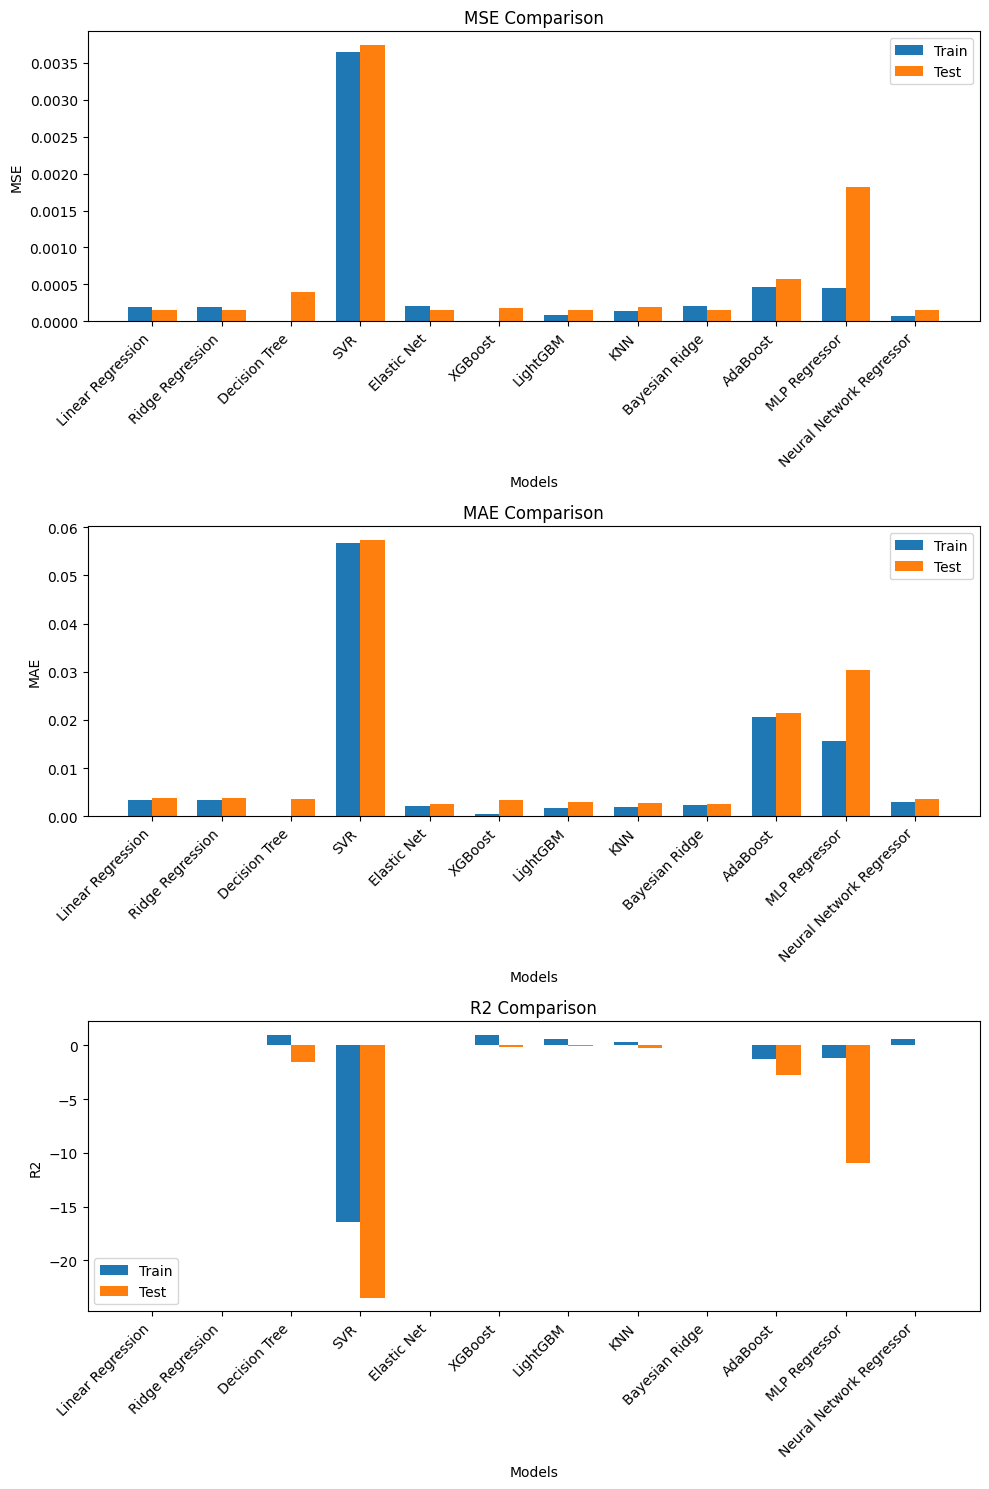

In [85]:
# Function to plot comparison bar chart
def plot_comparison_chart(models, data_train, data_test, metric, ax):
    n = len(models)
    index = np.arange(n)
    bar_width = 0.35

    ax.bar(index, data_train[metric], bar_width, label='Train')
    ax.bar(index + bar_width, data_test[metric], bar_width, label='Test')

    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()

fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 15))

for i, metric in enumerate(metrics):
    plot_comparison_chart(models, data_train, data_test, metric, axs[i])

plt.tight_layout()
plt.show()